<a href="https://colab.research.google.com/github/subhodipbiswas/named_person_parser/blob/main/name_person_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Creating a name person parser using BERT**

In this notebook, we are going to a create a basic **Named Person Parser** based on the [Transformers library](https://github.com/huggingface/transformers). This problems has the same flavor as Named Entity Recognition (**NER**) except that a named entity parser **processes a piece of text that contains names of people**, it typically outputs a structured representation of the entities it has identified. Here, the base model is BERT, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. NER is typically treated as a token classification problem, so that's what we are going to use it for.

This attempt is based on the idea of **transfer learning**, where a large neural network (NN) undergoes unsupervised training, and is then fine-tuned on a specific task of interest. In this case, BERT is the pretrained NN that we use. Now, we are going to fine-tune this network on a [dataset of person names](https://github.com/datamade/probablepeople/blob/master/name_data/labeled/person_labeled.xml). Most likely this dataset contains names of professors in Computer Science.

#### **Importing dependencies and preparing the environment**

It is assumed that the following libraries are installed:
```
* pandas
* numpy
* sklearn
* pytorch
* transformers
* seqeval
```
Note that this experiment was performed in Google Colab Pro. The only additional libraries we need to install are transformers and seqeval (GPU version). GPUs are preferred since runtime in deep learning can be shortened significantly using a GPU instead of a CPU. This notebook uses GPU runtime (in Google Colab, you can - check "Runtime" - "Change runtime type" - and set the hardware accelerator to "GPU").

In [1]:
!python --version

Python 3.9.16


In [ ]:
!pip install seqeval[gpu]
!pip install transformers==4.11.3

In [3]:
import torch
import pandas as pd
import numpy as np



We can set the default device to GPU using the following code (if it prints "cuda", it means the GPU has been recognized):

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Downloading and preprocessing the data**

I have already downloaded the file and stored it in Google Drive. I will just access it from Google Drive.

In [5]:
!pip install xmltodict
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import sys
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

#Append the directory to your python path using sys
prefix = '/content/drive/My Drive/'

Mounted at /content/drive


#### Read the file and use `xmltodict` library to generate a dictionary

In [7]:
import xmltodict

In [8]:
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'Job Application/2023/Veryfi/'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
xml_file_location = sys_path + 'person_labeled.xml'

In [9]:
xml_file_location

'/content/drive/My Drive/Job Application/2023/Veryfi/person_labeled.xml'

In [10]:
# Load the XML file
with open(xml_file_location) as f:
    xml_data = f.read()

# Convert the XML data to a Python dictionary
data_dict = xmltodict.parse(xml_data)

#### Parse the data dictionary, separate out the names and corresponding tags

There could be multiple variations of how names are written like `Patrick "The Hoya Destroya" Ewing`, `Dr. & Mrs. MIGUEL A ESPINAL SANTOS`, and so on. In the interest of time, I have written a very basic filtering scheme that removes any special character from a name and translates them to lowercase.

In [11]:
import re

def filter_string(s):
  if s == "&":
    return "And"
  try:
    return re.sub("[^A-Z]", "", s, 0, re.IGNORECASE).lower()
  except Exception as e:
    print(f" Exception {e} for {s} of type {type(s)}")
    return s.lower()

Scan each name and translate them in easy-to-work with format. For instance, `<Name><GivenName>Yaming</GivenName> <Surname>Yu</Surname></Name>` should be translate to `['Yaming', 'Yu'] 
 ['GivenName', 'Surname']`.

In [12]:
texts, tags = [], []

person_id = 0
for person in tqdm(data_dict['NameCollection']['Name']):
  person_id += 1
  name_doc, name_tag = [], []

  for tag, name in person.items():
    try:
      if type(name) is not list:
        name_doc.append(filter_string(name))
        name_tag.append(tag)
      else:
        for nam in name:
          name_doc.append(filter_string(nam))
          name_tag.append(tag)
    except Exception as e:
      print(f"Encountered {e} for {name} \t {type(name)}")
      person_id -= 1
      continue

  # Update the main files "docs" and "tags"
  texts.append(name_doc)
  tags.append(name_tag)

print(f"len(texts): {len(texts)} \t len(tags): {(len(tags))}")

100%|██████████| 2892/2892 [00:00<00:00, 24057.05it/s]

len(texts): 2892 	 len(tags): 2892



Putting out the statistics of differnet tags and their frequency: 

```
Number of tags: 12
GivenName             2350
Surname               2338
MiddleInitial          387
MiddleName             190
SuffixGenerational     165
SuffixOther            115
PrefixMarital          103
Nickname                97
And                     86
FirstInitial            70
PrefixOther             63
LastInitial             46
```

Except the majority tags `GivenName` and `Surname`, this dataset has class imbalance problem. More data can certainly help or using focal loss function. However, no such modifications were made here.

We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [13]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

#### **Preparing the dataset and dataloader**

Based on the classes defined above, 2 datasets have been created, one for training and one for testing using a `80/20 split`.

In [14]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_tags, val_tags = train_test_split(texts, tags, test_size=.2)

We use the [DistilBert](https://huggingface.co/docs/transformers/model_doc/distilbert) Fast Tokenizer` here as the pretrained NN. It is used to encode the data instances in the training and the test set.

In [15]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The labels are encoded as well. The padding-based encoding helps to achieve a smoother representation of the labels in the vector space and improved performance. 

In [16]:
def encode_tags(tags, encodings):
  labels = [[tag2id[tag] for tag in doc] for doc in tags]
  encoded_labels = []
  
  for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
      # create an empty array of -100
      doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
      arr_offset = np.array(doc_offset)
      try:
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())
      except Exception as e:
        encoded_labels.append(doc_enc_labels.tolist())
        continue
  
  return encoded_labels

In [17]:
train_labels = encode_tags(train_tags, train_encodings)

In [18]:
val_labels = encode_tags(val_tags, val_encodings)

Prepare the dataset using a custom class based on `torch.utils`. This helps in speeding up the data access during the training process

In [19]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
train_dataset = Dataset(train_encodings, train_labels)
val_encodings.pop("offset_mapping")
val_dataset = Dataset(val_encodings, val_labels)

So far all our efforts have been focused on preparing the data. This involved parsing the XML file, getting list of names and tags, basic text preprocessing, tokenizing and encoding the preprocessed text and tags into numerical representation. While this may appear simple, majority of my time went into this preprocessing. Now the hard part is done, let the magic begin!

## **Transformers are all we need**

As the name suggests, indeed transformers comes to our rescue here. A deep learning model is initialized using a pretrained [DistilBert](https://huggingface.co/distilbert-base-uncased#model-description) base model. The number of labels have been set to 12, which is the number of name tags available in the dataset.

In [ ]:
from transformers import DistilBertForTokenClassification
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_tags))

In [21]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from transformers import AdamW
from tqdm import tqdm

Create the training set loader using the built-in `DataLoader` library. Then set the model to GPU for faster training. The [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#adamw) optimizer is used here. While there can be multiple ways to tweak around the hyperparameters and configurations, we went with a pretty vanilla model. Only the number of epochs for training was set to 100.

In [22]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [24]:
NUM_EPOCHS = 10

### Train/Fine-tune the model to the task of named person identification.

Ideally, this is transfer learning taking place. The training accuracy and loss is shown below for every 10 epochs.

In [25]:
# put model in training mode
model.train()
for epoch in tqdm(range(NUM_EPOCHS)):

  tr_loss, tr_accuracy = 0, 0
  nb_tr_examples, nb_tr_steps = 0, 0
  tr_preds, tr_labels = [], []
  
  for batch in train_loader:
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Get the batch loss and the training logit
    loss = outputs[0]
    tr_logits = outputs[1]
    tr_loss += loss.item()
    
    nb_tr_steps += 1
    nb_tr_examples += labels.size(0)
        
    # compute training accuracy
    flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
    active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

    # only compute accuracy at active labels
    active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
    #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

    labels = torch.masked_select(flattened_targets, active_accuracy)
    predictions = torch.masked_select(flattened_predictions, active_accuracy)

    tr_labels.extend(labels)
    tr_preds.extend(predictions)

    tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
    tr_accuracy += tmp_tr_accuracy

    # backward pass
    loss.backward()
    optim.step()

  if epoch % 10 == 0:
    print(f"\n Training loss in epoch {epoch + 1}: {tr_loss / nb_tr_steps}")
    print(f" Training accuracy epoch: {tr_accuracy / nb_tr_steps}\n")

 10%|█         | 1/10 [00:10<01:31, 10.21s/it]


 Training loss in epoch 1: 0.5887275546789169
 Training accuracy epoch: 0.812770226768593



100%|██████████| 10/10 [01:16<00:00,  7.65s/it]


#### **Evaluating the model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is `20%` of the data). Note that here, no gradient updates are performed, the model just outputs its logits. 

In [26]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.append(labels)
            eval_preds.append(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [['B-' + id2tag[id.item()] for id in item] for item in eval_labels]
    predictions = [['B-' + id2tag[id.item()] for id in item] for item in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [27]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
labels, predictions = valid(model, val_loader)

Validation Loss: 0.7518181993103497
Validation Accuracy: 0.8495517723497


However, the accuracy metric is misleading, as there is class imbalance. Hence, it is important to look at the precision, recall and f1-score of the individual tags. For this, we use the seqeval Python library.

In [28]:
from seqeval.metrics import classification_report

print(classification_report(labels, predictions))

                    precision    recall  f1-score   support

               And       1.00      1.00      1.00        12
      FirstInitial       0.90      0.90      0.90        10
         GivenName       0.89      0.91      0.90       461
       LastInitial       1.00      1.00      1.00        14
     MiddleInitial       0.97      1.00      0.99        72
        MiddleName       0.76      0.88      0.81        32
          Nickname       0.95      0.83      0.89        24
     PrefixMarital       1.00      0.93      0.97        15
       PrefixOther       0.91      1.00      0.95        10
SuffixGenerational       1.00      1.00      1.00        23
       SuffixOther       0.91      1.00      0.95        20
           Surname       0.91      0.87      0.89       458

         micro avg       0.91      0.91      0.91      1151
         macro avg       0.93      0.94      0.94      1151
      weighted avg       0.91      0.91      0.91      1151



We do notice that for `MiddleName` and `Nickname`, the performance is somewhat on the lower end. This is possible for minority classes. I think this has to do with the nature of the dataset as well. This dataset is mostly based on names of researchers/scholars in U.S.A. It is quite possible that such datasets are predominantly skewed towards certain ethnicities while missing out others. For instance, lets say, if the proportion of Hispanic names are low in the dataset, it is highly likely that the model will perform poorly in identifying named entities of Hispanic names.

That is to say that model hasn't been fine-tuned well enough on representative sample of names. So more data can be beneficial. Continual learning is the way to go. Also, better preprocessing of text may lead to better performance.

### Save the model

Saving this model might be a good idea after so much work in building it. I gave a custom location to save it in my Google Drive. Feel free to give your own custom location.

In [29]:
model_location = "NERModel1"

if not os.path.exists(sys_path + model_location):
    os.makedirs(sys_path + model_location)

# save vocabulary of the tokenizer
tokenizer.save_vocabulary(sys_path + model_location)
# save the model weights and its configuration file
model.save_pretrained(sys_path + model_location)
print('All files saved')

All files saved


#### **Inference**

The fun part is when we can quickly test the model on new, unseen sentences. 
Here, I input my name along with the nickname and ask the model to predict it. 


In [30]:
sentence = "Subhodip 'Leo' Biswas"

inputs = tokenizer(sentence.lower().split(),
                   is_split_into_words=True,
                   return_offsets_mapping=True,
                   padding=True,
                   truncation=True,
                   return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2tag[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

print(sentence.split())
print(prediction)

['Subhodip', "'Leo'", 'Biswas']
['GivenName', 'Nickname', 'Surname']


# **Yup, identifies it pretty well.**

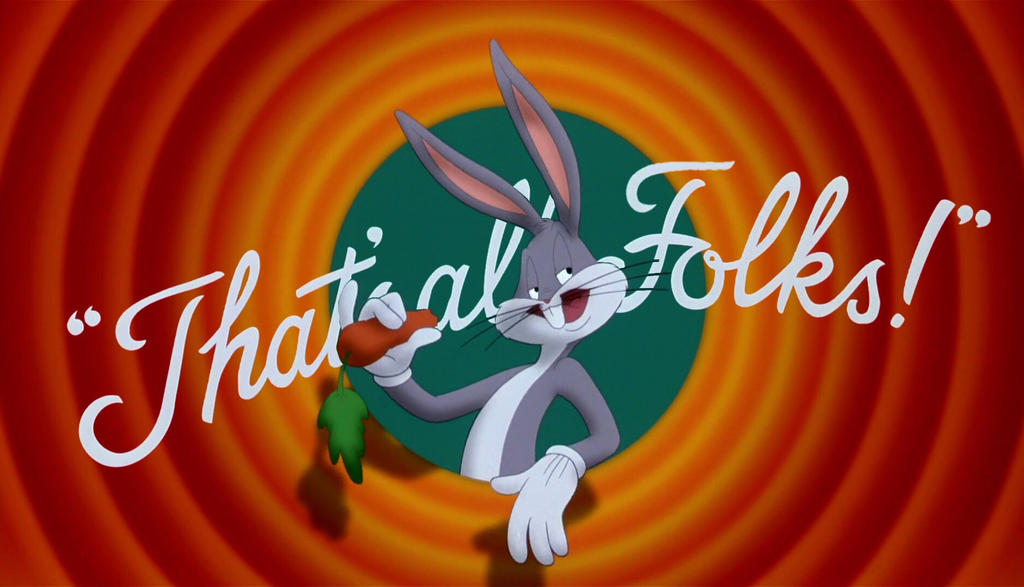